In [108]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

https://towardsdatascience.com/predicting-premier-league-standings-putting-that-math-to-some-use-e8de64938d7

## **Construct the current League Table - ordered by points (3 for a win, 1 for a draw), goal difference and then goals scored and output as a csv – called league_table.csv**

In [109]:
df = pd.read_csv('sample_data.csv')
df

,Match ID,Home ID,Away ID,1,X,2,Score
0,1,5,17,3.28,3.20,2.39,1:1
1,2,6,18,2.35,3.45,3.07,3:1
2,3,10,8,1.22,6.54,16.16,2:0
3,4,14,11,3.33,3.57,2.20,1:3
4,5,16,15,3.06,3.55,2.33,2:2
...,...,...,...,...,...,...,...
155,156,18,10,7.05,4.08,1.54,2:2
156,157,6,11,4.15,3.83,1.88,1:3
157,158,17,3,6.38,4.53,1.52,1:2
158,159,9,8,1.31,5.66,10.94,4:0


In [110]:
display(df['Home ID'].value_counts())
display(df['Away ID'].value_counts())

5     9
6     9
14    9
4     9
3     8
20    8
13    8
15    8
17    8
11    8
1     8
2     8
12    8
16    8
10    8
18    8
8     7
9     7
19    7
7     7
Name: Home ID, dtype: int64

9     9
8     9
7     9
19    9
18    8
10    8
16    8
2     8
12    8
1     8
17    8
13    8
3     8
20    8
15    8
11    8
14    7
6     7
5     7
4     7
Name: Away ID, dtype: int64

## Constructing a Python dictionary

Given we will be looping through the dataset in order to obtain information regarding some index (Team ID), a Python Dictionary is appropriate as they are very fast when accessing data, in addition to being intuitive.

The average case complexity for delete and update operations are O(1) and O(n) for construction of new keys

In [111]:
# define dictionary
league_table_dict = {}
# iterate through Home or Away ID column to obtain unique keys
for index in df['Home ID'].values:
    if index in league_table_dict:
       pass
    else:
       # define a sub_dict for each key which will include all other variables. Others may prefer tuples or lists
       league_table_dict[index] = {'Wins':0,'Draws':0,'Losses':0,'Points':0, 'GD':0, 'GS':0} 

for index, row in df.iterrows(): 
    # for each match, obtain Team IDs and the number of goals per team
    home_id = row['Home ID']
    away_id = row['Away ID']
    home_score = int(row['Score'].split(':')[0])
    away_score = int(row['Score'].split(':')[1])
    home_GD = home_score - away_score
    away_GD = away_score - home_score

    # for each match, update GD & GS for each team
    league_table_dict[home_id]['GS'] += home_score
    league_table_dict[away_id]['GS'] += away_score
    league_table_dict[home_id]['GD'] += home_GD
    league_table_dict[away_id]['GD'] += away_GD

    # in case of home team win
    if home_score > away_score:
       league_table_dict[home_id]['Points'] += 3
       league_table_dict[home_id]['Wins'] += 1
       league_table_dict[away_id]['Losses'] += 1
    # in case of away team win
    elif home_score < away_score:
       league_table_dict[away_id]['Points'] += 3
       league_table_dict[away_id]['Wins'] += 1
       league_table_dict[home_id]['Losses'] += 1
    # in case of a draw
    else:
       league_table_dict[home_id]['Points'] += 1
       league_table_dict[away_id]['Points'] += 1
       league_table_dict[away_id]['Draws'] += 1
       league_table_dict[home_id]['Draws'] += 1


### Task 1 Results

In [112]:
league_table_dict

{1: {'Draws': 2, 'GD': 17, 'GS': 35, 'Losses': 2, 'Points': 38, 'Wins': 12},
 2: {'Draws': 1, 'GD': 5, 'GS': 24, 'Losses': 7, 'Points': 25, 'Wins': 8},
 3: {'Draws': 4, 'GD': 16, 'GS': 35, 'Losses': 2, 'Points': 34, 'Wins': 10},
 4: {'Draws': 3, 'GD': -4, 'GS': 23, 'Losses': 6, 'Points': 24, 'Wins': 7},
 5: {'Draws': 7, 'GD': -13, 'GS': 17, 'Losses': 8, 'Points': 10, 'Wins': 1},
 6: {'Draws': 2, 'GD': -3, 'GS': 26, 'Losses': 7, 'Points': 23, 'Wins': 7},
 7: {'Draws': 0, 'GD': 5, 'GS': 27, 'Losses': 7, 'Points': 27, 'Wins': 9},
 8: {'Draws': 7, 'GD': -14, 'GS': 17, 'Losses': 8, 'Points': 10, 'Wins': 1},
 9: {'Draws': 4, 'GD': 24, 'GS': 39, 'Losses': 1, 'Points': 37, 'Wins': 11},
 10: {'Draws': 3, 'GD': 6, 'GS': 22, 'Losses': 5, 'Points': 27, 'Wins': 8},
 11: {'Draws': 4, 'GD': 2, 'GS': 32, 'Losses': 5, 'Points': 25, 'Wins': 7},
 12: {'Draws': 3, 'GD': 22, 'GS': 34, 'Losses': 2, 'Points': 36, 'Wins': 11},
 13: {'Draws': 2, 'GD': -22, 'GS': 11, 'Losses': 12, 'Points': 8, 'Wins': 2},
 14: 

In [113]:
# define column names 
column_names = ['TeamID','W','D','L','GD','GF','Points']

# instantiate new pandas dataframe
league_table_df = pd.DataFrame(columns=column_names)

# append all key-value pairs as df rows
for key in league_table_dict:
    league_table_df = league_table_df.append({'TeamID':key,'W':league_table_dict[key]['Wins'],'D':league_table_dict[key]['Draws'],
                                              'L':league_table_dict[key]['Losses'],'GD':league_table_dict[key]['GD'],
                                              'GF':league_table_dict[key]['GS'],'Points':league_table_dict[key]['Points']}, ignore_index=True)

# sort descending order (points)
league_table_df = league_table_df.sort_values(by='Points',ascending=False)
league_table_df = league_table_df.reset_index()
league_table_df = league_table_df.drop(['index'],axis=1)

In [114]:
league_table_df.to_csv('league_table.csv')
display(league_table_df.head(20))

,TeamID,W,D,L,GD,GF,Points
0,1,12,2,2,17,35,38
1,9,11,4,1,24,39,37
2,12,11,3,2,22,34,36
3,3,10,4,2,16,35,34
4,10,8,3,5,6,22,27
5,7,9,0,7,5,27,27
6,11,7,4,5,2,32,25
7,2,8,1,7,5,24,25
8,4,7,3,6,-4,23,24
9,20,6,5,5,4,32,23


## **TASK 2: Produce prices (without margin) for the upcoming fixtures, replacing the ?s with probabilities in the file upcoming_fixtures.csv -- Poisson Distribution for predicting football match outcomes**

The **Poisson Distribution** is a discrete probability distribution that estimates the probability of some events/states (HT win, draw, etc) occurring in a fixed interval of time and independent of the last event. 

In [115]:
HG_list = []
AG_list = []
for index, row in df.iterrows():
    HG = row['Score'].split(':')[0]
    AG = row['Score'].split(':')[1]
    HG_list.append(HG)
    AG_list.append(AG)
  
df['HomeGoals'] = HG_list
df['AwayGoals'] = AG_list

In [116]:
df = df.drop(['1','X','2','Score','Match ID'],axis=1)
df = df.rename(columns={'Home ID': 'HomeTeam', 'Away ID': 'AwayTeam'})


In [117]:
df['HomeGoals'] = pd.to_numeric(df['HomeGoals'])
df['AwayGoals'] = pd.to_numeric(df['AwayGoals'])

In [118]:
df[['HomeGoals','AwayGoals']].mean()

HomeGoals    1.67500
AwayGoals    1.41875
dtype: float64

On average, the home team scores around a quarter of a goal more than the away team average. Therefore, the model will need to handle the home advantage.

In [119]:
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,5,17,1,1
1,6,18,3,1
2,10,8,2,0
3,14,11,1,3
4,16,15,2,2


Text(0.5, 1.0, 'Number of Goals Scored')

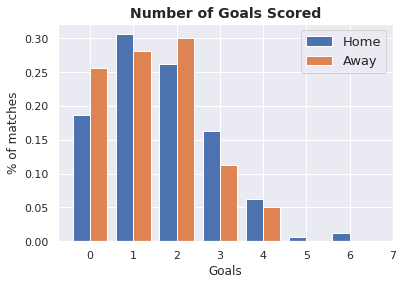

In [120]:
sns.set()

max_goals = 8
plt.hist(
    df[["HomeGoals", "AwayGoals"]].values, range(max_goals), label=["Home", "Away"], density=True
)
plt.xticks([i + 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("% of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored", size=14, fontweight="bold")

The barchart above show some similarity to the Poisson Distribution (shown below)

(array([0.16591667, 0.18816667, 0.18641667, 0.13808333, 0.08616667,
        0.05825   , 0.00691667, 0.00225   , 0.00058333, 0.00058333]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

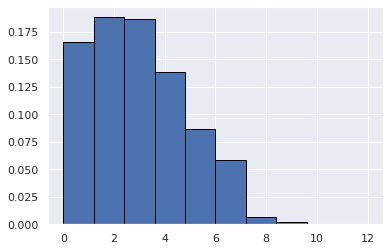

In [121]:
x = poisson.rvs(mu=3, size=10000)
plt.hist(x, density=True, edgecolor='black')

In [122]:
goal_model_data = pd.concat([df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  320
Model:                            GLM   Df Residuals:                      316
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -490.16
Date:                Tue, 08 Mar 2022   Deviance:                       355.87
Time:                        17:30:00   Pearson chi2:                     296.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3661      0.135      2.717      0.007       0.102       0.630
home           0.1609      0.090      1.783      0.075      -0.016       0.338
team          -0.0155      0.008     -1.987      0.047      -0.031      -0.000
opponent       0.0135      0.008      1.732      0.083      -0.002       0.029
==============================================================================
"""

In [123]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=6):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]

    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

a = simulate_match(poisson_model, 1, 6, max_goals=6)

In [124]:
print(a)

[[4.32647182e-02 5.76148588e-02 3.83623434e-02 1.70288177e-02
  5.66924371e-03 1.50992628e-03 3.35123680e-04]
 [7.82544323e-02 1.04210041e-01 6.93873329e-02 3.08006273e-02
  1.02541624e-02 2.73105729e-03 6.06150102e-04]
 [7.07707854e-02 9.42442012e-02 6.27516666e-02 2.78550942e-02
  9.27353388e-03 2.46988016e-03 5.48182608e-04]
 [4.26685443e-02 5.68209446e-02 3.78337226e-02 1.67941661e-02
  5.59112336e-03 1.48911998e-03 3.30505784e-04]
 [1.92940279e-02 2.56935151e-02 1.71077994e-02 7.59405114e-03
  2.52821584e-03 6.73356050e-04 1.49449387e-04]
 [6.97955868e-03 9.29455464e-03 6.18869688e-03 2.74712600e-03
  9.14574757e-04 2.43584600e-04 5.40628828e-05]
 [2.10402927e-03 2.80189851e-03 1.86561931e-03 8.28137393e-04
  2.75703974e-04 7.34300195e-05 1.62975760e-05]]


### Test run

In [125]:
# win for home team / loss for away team
print(np.sum(np.tril(a, -1)))
# draw
print(np.sum(np.diag(a)))
# win for away team / loss for home team
print(np.sum(np.triu(a, 1)))

0.48435535331617624
0.22980869002664092
0.28273395182904293


In [126]:
upcoming_df = pd.read_csv('/content/upcoming_fixtures.csv')
upcoming_df.head()

,Unnamed: 0,Match ID,Home ID,Away ID,1,X,2
0,0,161,8,14,0.493,0.230,0.274
1,1,162,7,13,0.493,0.230,0.274
2,2,163,19,10,0.346,0.240,0.412
3,3,164,18,1,0.275,0.230,0.492
4,4,165,17,4,0.309,0.236,0.452


In [127]:
def obtain_probabilities(df):
    win_list = []
    draw_list = []
    loss_list = []

    for index, match in df.iterrows():

        home_team = match['Home ID']
        away_team = match['Away ID']
        a = simulate_match(poisson_model, home_team, away_team, max_goals=6)

        # win for home team / loss for away team
        win_prob = round(np.sum(np.tril(a, -1)),3)
        # draw
        draw_prob = round(np.sum(np.diag(a)),3)
        # win for away team / loss for home team
        loss_prob = round(np.sum(np.triu(a, 1)),3)

        # append to lists
        win_list.append(win_prob)
        draw_list.append(draw_prob)
        loss_list.append(loss_prob)

    # append to dataframe
    df['1'] = win_list
    df['X'] = draw_list
    df['2'] = loss_list

    return df

In [128]:
upcoming_df = obtain_probabilities(upcoming_df)
display(upcoming_df.head())
upcoming_df.to_csv('upcoming_fixtures.csv')

,Unnamed: 0,Match ID,Home ID,Away ID,1,X,2
0,0,161,8,14,0.493,0.230,0.274
1,1,162,7,13,0.493,0.230,0.274
2,2,163,19,10,0.346,0.240,0.412
3,3,164,18,1,0.275,0.230,0.492
4,4,165,17,4,0.309,0.236,0.452


## **Task 3: Finally calculate the probability of each team winning the league, finishing in the top 4 and being relegated (bottom 3) and output as a csv. (Every team plays everyone else, home and away.)**

**The number of possible league table outcomes is too high. Therefore, implementing a brute-force approach which multiples the probability sequences of all possible outcomes will not solve the problem at hand as it would take too long**

Algorithm:


1.   Start with a league table with matches played so far 
2.   Use the match result probabilities (W/D/L) to randomly choose results of all remaining matches (using weights)
3.   Calculate the final league table and note down the results
4.   Repeat as many times as necessary

**The probabilities for rest_of_season matches are obtained as shown below**

In [129]:
rest_season_df = pd.read_csv('/content/rest_of_season.csv')
rest_season_df = obtain_probabilities(rest_season_df)
display(rest_season_df.head())


,Match ID,Home ID,Away ID,1,X,2
0,181,1,6,0.484,0.230,0.283
1,182,2,14,0.553,0.217,0.226
2,183,3,8,0.484,0.230,0.283
3,184,4,15,0.543,0.220,0.233
4,185,5,10,0.483,0.231,0.283


**The upcoming_fixtures and rest_of_season datasets are concatonated onto one dataframe**

In [130]:
final_df = pd.concat([upcoming_df,rest_season_df],axis=0)

**WARNING: The following cell will take a while to run (20 mins)**. Instead take a look at the **final_probabilities** csv file or decrease the **no_of_simulations** value

---



In [131]:
# obtain current league table
league_table = pd.read_csv('/content/league_table.csv')
league_table = league_table.drop(['Unnamed: 0','GD','GF'],axis=1)
league_table = league_table.set_index('TeamID')

# dictionary

results_dict = {}

# monte carlo simulation (random walk)

no_of_simulations = 10000

for i in range(no_of_simulations):
    league_table_df = league_table.copy()
    for index, match in final_df.iterrows(): 
        home_id = match['Home ID']
        away_id = match['Away ID']

        if home_id not in results_dict:
           results_dict[int(home_id)] = {'Champion':0,'Top4':0,'Bottom3':0}
        
        resultList = ['1','X','2']

        outcome = random.choices(resultList, weights=(match['1'],match['X'],match['2']))[0]

        # win for home team
        if outcome == '1':
          league_table_df.loc[home_id]['W'] += 1
          league_table_df.loc[away_id]['L'] += 1
          league_table_df.loc[home_id]['Points'] += 3
        # draw   
        elif outcome == 'X':
          league_table_df.loc[home_id]['D'] += 1
          league_table_df.loc[away_id]['D'] += 1
          league_table_df.loc[home_id]['Points'] += 1
          league_table_df.loc[away_id]['Points'] += 1
        # loss
        else:
          league_table_df.loc[home_id]['L'] += 1
          league_table_df.loc[away_id]['W'] += 1
          league_table_df.loc[away_id]['Points'] += 3

    league_table_df = league_table_df.sort_values(by='Points',ascending=False)
    league_table_df = league_table_df.reset_index()
    #display(league_table_df)

    # iterate through dictionary, get ranking of each team and update dict values
    for key in results_dict:
        position = league_table_df.index[league_table_df['TeamID']==key].tolist()[0]

        if position >= 0 and position <= 3:
           results_dict[key]['Top4'] += 1
           if position == 0:
              results_dict[key]['Champion'] += 1
        elif position >= 17 and position <= 19:
           results_dict[key]['Bottom3'] += 1
        else:
           pass 

**Test**

In [132]:
sum = 0
for key in results_dict:
    sum += results_dict[key]['Champion']

print(sum)

10000


**Convert count to probability for each outcome and save to csv**

In [133]:
for key, value in results_dict.items():
    value['Champion'] = value['Champion']/no_of_simulations
    value['Top4'] = value['Top4']/no_of_simulations
    value['Bottom3'] = value['Bottom3']/no_of_simulations

In [134]:
results_dict

{1: {'Bottom3': 0.0, 'Champion': 0.5763, 'Top4': 0.9517},
 2: {'Bottom3': 0.0, 'Champion': 0.0144, 'Top4': 0.2781},
 3: {'Bottom3': 0.0, 'Champion': 0.1706, 'Top4': 0.7817},
 4: {'Bottom3': 0.0002, 'Champion': 0.0065, 'Top4': 0.1673},
 5: {'Bottom3': 0.2245, 'Champion': 0.0, 'Top4': 0.0005},
 6: {'Bottom3': 0.0038, 'Champion': 0.0032, 'Top4': 0.0815},
 7: {'Bottom3': 0.0004, 'Champion': 0.0117, 'Top4': 0.2402},
 8: {'Bottom3': 0.3053, 'Champion': 0.0, 'Top4': 0.0001},
 9: {'Bottom3': 0.0, 'Champion': 0.1477, 'Top4': 0.7495},
 10: {'Bottom3': 0.0016, 'Champion': 0.005, 'Top4': 0.1263},
 11: {'Bottom3': 0.0032, 'Champion': 0.0014, 'Top4': 0.0713},
 12: {'Bottom3': 0.0, 'Champion': 0.0632, 'Top4': 0.5425},
 13: {'Bottom3': 0.6587, 'Champion': 0.0, 'Top4': 0.0},
 14: {'Bottom3': 0.2572, 'Champion': 0.0, 'Top4': 0.0005},
 15: {'Bottom3': 0.0744, 'Champion': 0.0, 'Top4': 0.0041},
 16: {'Bottom3': 0.5327, 'Champion': 0.0, 'Top4': 0.0},
 17: {'Bottom3': 0.1335, 'Champion': 0.0, 'Top4': 0.0015}

In [135]:
# define column names 
column_names = ['TeamID','Bottom3','Champion','Top4']

# instantiate new pandas dataframe
final_prob_df = pd.DataFrame(columns=column_names)

# append all key-value pairs as df rows
for key in results_dict:
    final_prob_df = final_prob_df.append({'TeamID':int(key),'Bottom3':results_dict[key]['Bottom3'],'Champion':results_dict[key]['Champion'],
                                          'Top4':results_dict[key]['Top4']},ignore_index=True)

# Sort dataframe by team index and save to csv
final_prob_df = final_prob_df.sort_values(by='TeamID',ascending=True)
final_prob_df = final_prob_df.reset_index()
final_prob_df = final_prob_df.drop(['index'],axis=1)
final_prob_df.to_csv('final_probabilities.csv')

## **FUTURE WORK**

#### One thing to consider is that for TASK 3, there is the possibility to have two teams with the same number of points. Therefore it would be interesting to apply a monte carlo simulation for different score results in order to obtain Goal Difference estimates. Maybe its not a good idea but just a thought that I had



#### Experiment with different distributions and techniques. It would be interesting to try out machine learning approaches for match result predictions

#### Obtain as much relevant data as possible (as well through feature engineering) and try to build a model as accurate as possible whilst keeping in mind the trade offs between accuracy and computational cost.

# **END**